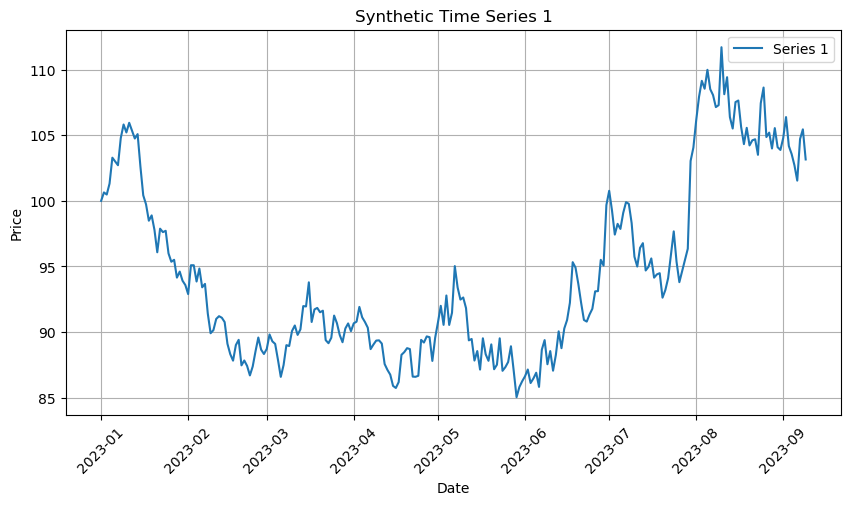

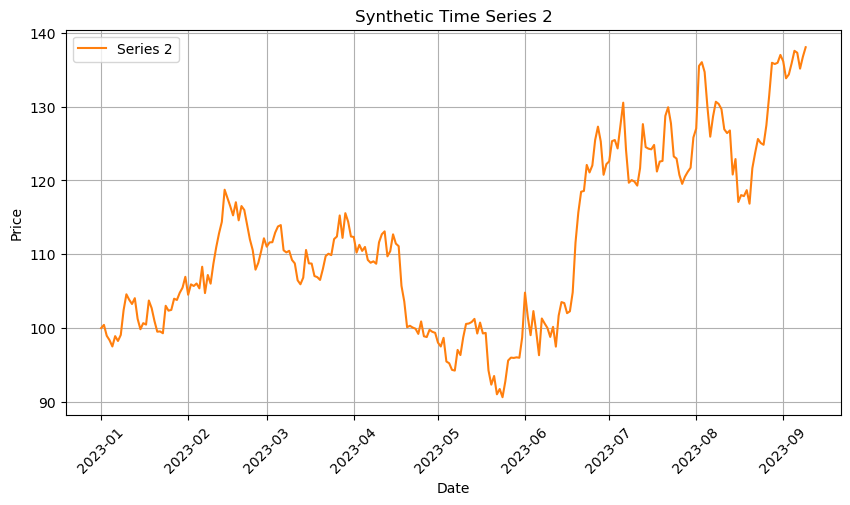

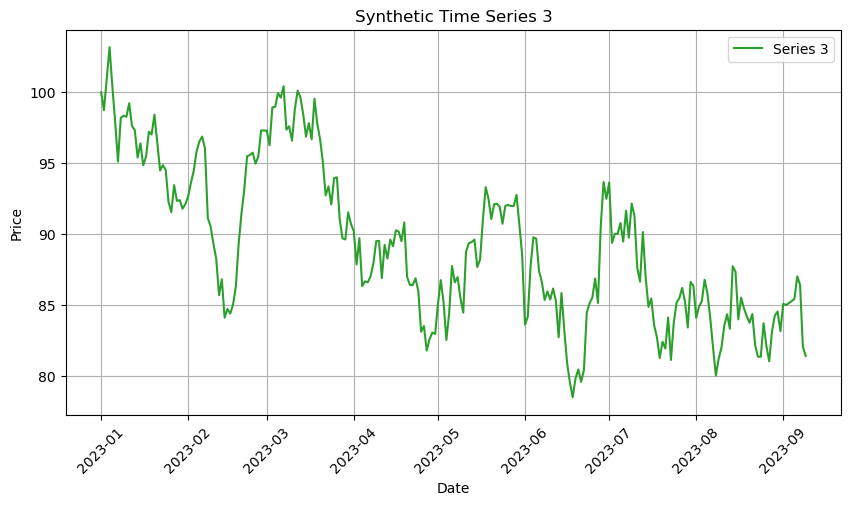

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Folder where the CSV files are stored
DATA_FOLDER = "data/"

# List of CSV files for the first three synthetic series
csv_files = [os.path.join(DATA_FOLDER, f"synthetic_series_{i+1}.csv") for i in range(3)]

# Function to read and plot synthetic time series separately
def plot_synthetic_series_separate(csv_files):
    for i, csv_file in enumerate(csv_files):
        if os.path.exists(csv_file):
            # Read CSV
            df = pd.read_csv(csv_file, parse_dates=["Date"])

            # Create a new figure for each series
            plt.figure(figsize=(10, 5))
            plt.plot(df["Date"], df["Price"], label=f"Series {i+1}", color=f"C{i}")

            # Formatting
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.title(f"Synthetic Time Series {i+1}")
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()
        else:
            print(f"⚠️ Warning: {csv_file} not found. Skipping...")

# Plot each series separately
plot_synthetic_series_separate(csv_files)



🔄 Training on data/synthetic_series_1.csv...



/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_92596/1921181305.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input

Epoch 0/50 - Loss: 2272.5085
Epoch 10/50 - Loss: 3.5113
Epoch 20/50 - Loss: 3.4426
Epoch 30/50 - Loss: 3.3615
Epoch 40/50 - Loss: 2.1752


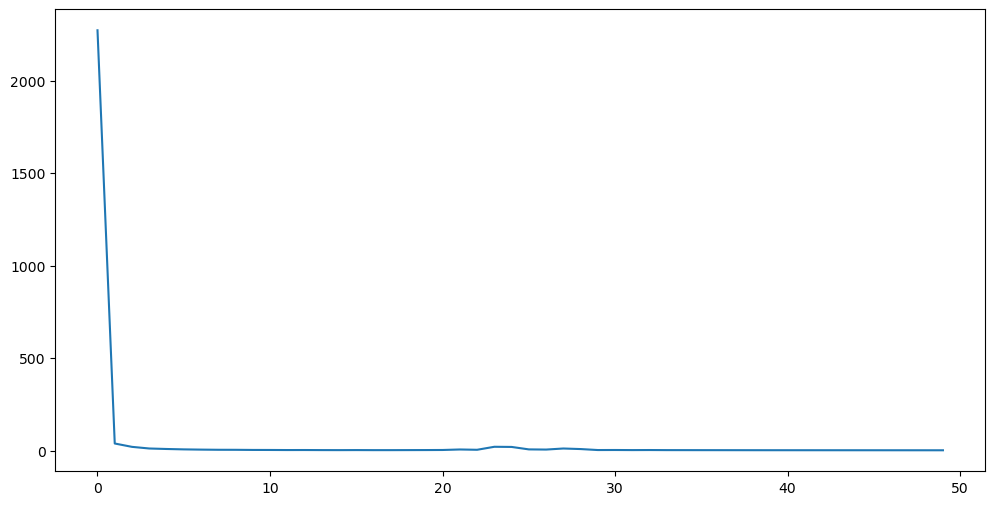

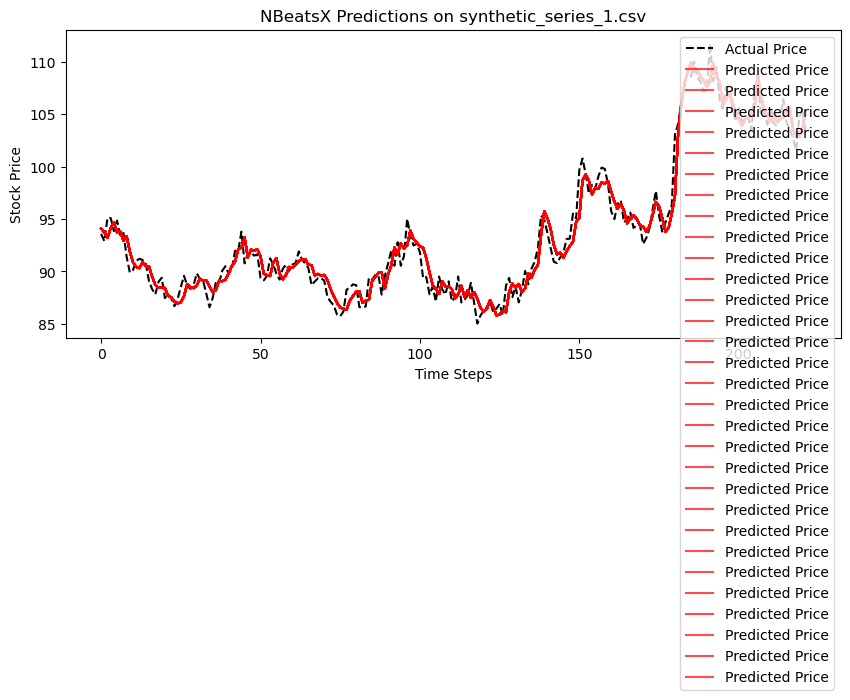


🔄 Training on data/synthetic_series_2.csv...

Epoch 0/50 - Loss: 3216.6751


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/50 - Loss: 8.5736
Epoch 20/50 - Loss: 6.5128
Epoch 30/50 - Loss: 2.9726
Epoch 40/50 - Loss: 2.4092


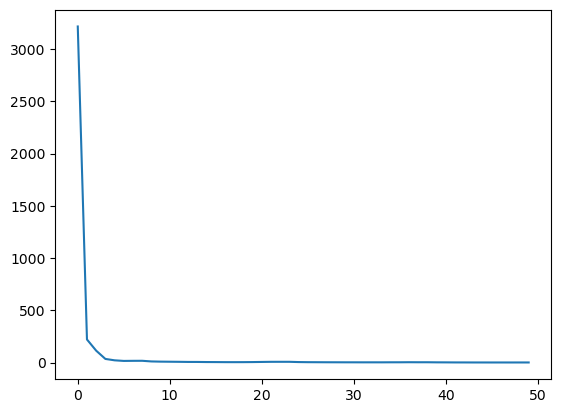

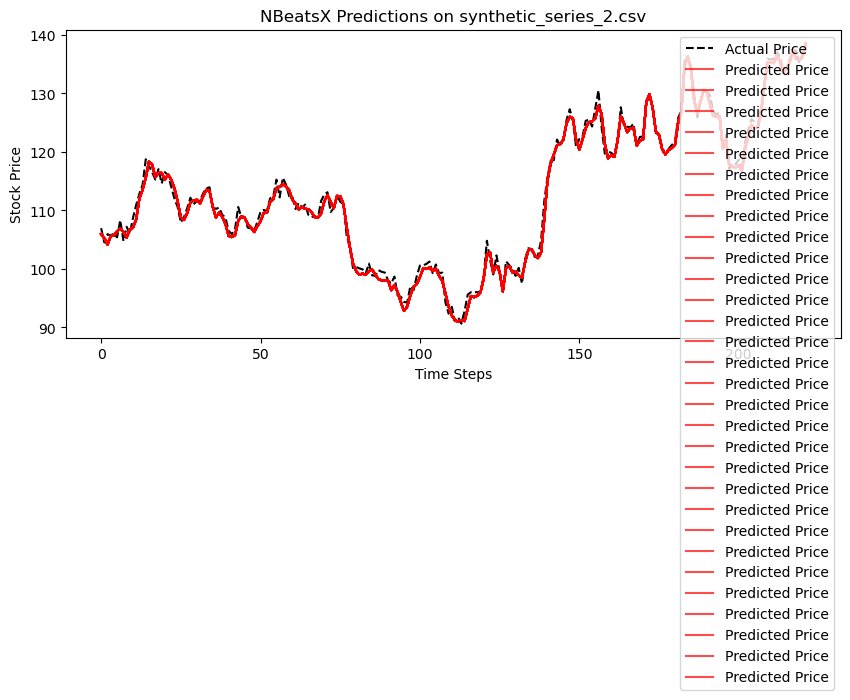


🔄 Training on data/synthetic_series_3.csv...

Epoch 0/50 - Loss: 1995.7881


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/50 - Loss: 3.3557
Epoch 20/50 - Loss: 1.6046
Epoch 30/50 - Loss: 0.6482
Epoch 40/50 - Loss: 0.9717


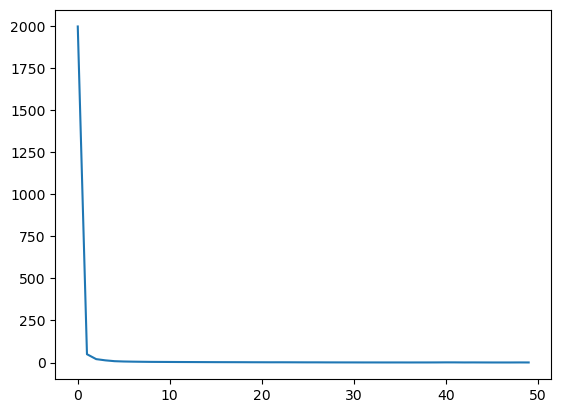

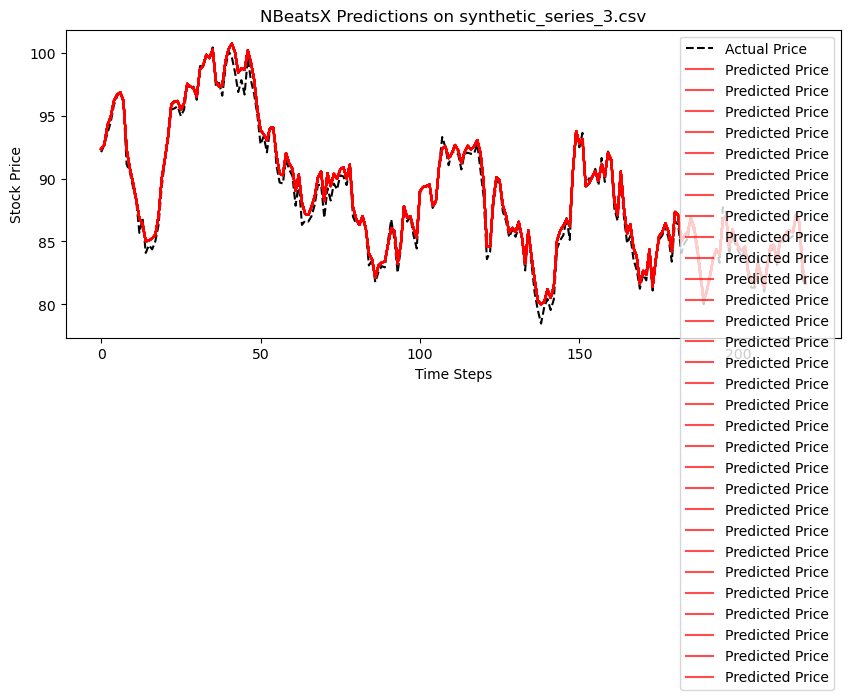

/var/folders/31/b1v52j156gbfz83pmrnth3jc0000gn/T/ipykernel_92596/1921181305.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


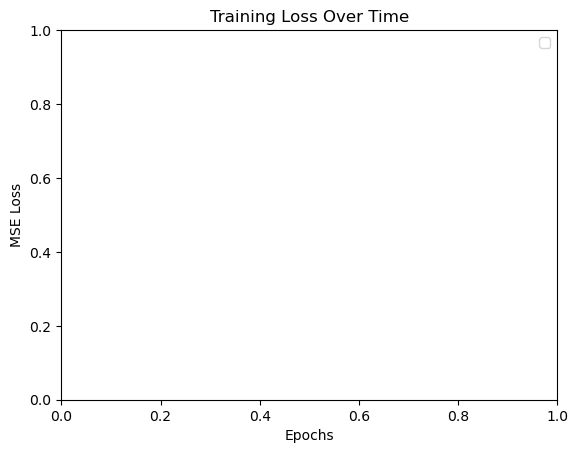

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.nbeatsx import NBeatsX  # Ensure correct import

# 🛠 Load Synthetic Data (3 CSV Files)
data_files = ["data/synthetic_series_1.csv", "data/synthetic_series_2.csv", "data/synthetic_series_3.csv"]

# 📌 Model Parameters
input_size = 30  # Lookback window
exog_size = 3    # Example: market index, volatility, economic indicators
output_size = 1  # Predicting next time step
hidden_units = 256
num_blocks = 3
epochs = 50
batch_size = 32
learning_rate = 0.001

# 🚀 Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Data Preprocessing Function
def prepare_data(df, input_size, exog_size):
    prices = df["Price"].values
    dates = df["Date"].values
    
    # Generate exogenous factors (randomized for testing)
    np.random.seed(42)
    exog_factors = np.random.uniform(0.9, 1.1, size=(len(prices), exog_size))

    X, Y, Exog = [], [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        Y.append(prices[i+input_size])  # Predict next time step
        Exog.append(exog_factors[i+input_size])  # Exog data aligns with target
    
    # Convert to Tensors
    X, Y, Exog = map(lambda x: torch.tensor(x, dtype=torch.float32), (X, Y, Exog))
    
    return X, Y.unsqueeze(1), Exog  # Ensure correct shape for training

# 🚀 Training Loop
def train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, lr):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size].to(device)
            y_batch = Y_train[i:i+batch_size].to(device)
            exog_batch = Exog_train[i:i+batch_size].to(device)
            
            optimizer.zero_grad()
            preds = model(x_batch, exog_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / (len(X_train) // batch_size)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")
    
    return losses

# 🚀 Train & Evaluate on Each Dataset
plt.figure(figsize=(12, 6))

for idx, file in enumerate(data_files):
    print(f"\n🔄 Training on {file}...\n")
    
    # 📌 Load & Prepare Data
    df = pd.read_csv(file)
    X_train, Y_train, Exog_train = prepare_data(df, input_size, exog_size)
    
    # 📌 Initialize Model
    model = NBeatsX(input_size=input_size, exog_size=exog_size, output_size=output_size, num_blocks=num_blocks, hidden_units=hidden_units).to(device)
    
    # 📌 Train Model
    losses = train_model(model, X_train, Y_train, Exog_train, epochs, batch_size, learning_rate)
    
    # 📈 Plot Training Loss
    plt.plot(losses, label=f"Series {idx+1}")

    # 📌 Make Predictions
    model.eval()
    with torch.no_grad():
        test_preds = model(X_train.to(device), Exog_train.to(device)).cpu().numpy()

    # 📊 Plot Forecasts
    plt.figure(figsize=(10, 4))
    plt.plot(Y_train.numpy(), label="Actual Price", linestyle="dashed", color="black")
    plt.plot(test_preds, label="Predicted Price", color="red", alpha=0.7)
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.title(f"NBeatsX Predictions on {file.split('/')[-1]}")
    plt.legend()
    plt.show()

# 🎯 Final Loss Graph
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()


1️⃣ CTTS Model (CNN + Transformer Time Series)


🔹 Training on data/synthetic_series_1.csv 🔹


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0: Loss 0.0769
Epoch 10: Loss 0.2851
Epoch 20: Loss 0.1074
Epoch 30: Loss 0.0716
Epoch 40: Loss 0.0656


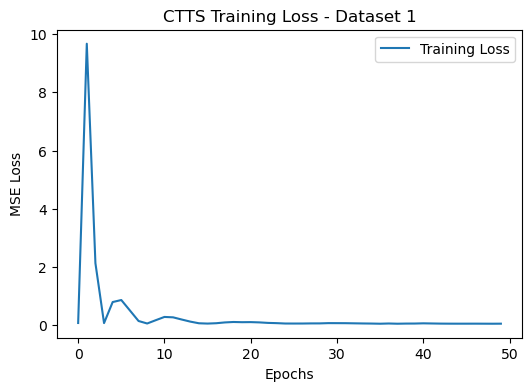

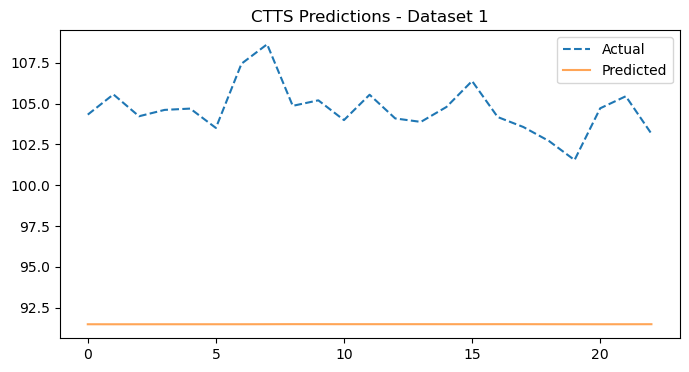


🔹 Training on data/synthetic_series_2.csv 🔹


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0: Loss 0.0625
Epoch 10: Loss 0.3173
Epoch 20: Loss 0.1145
Epoch 30: Loss 0.0728
Epoch 40: Loss 0.0613


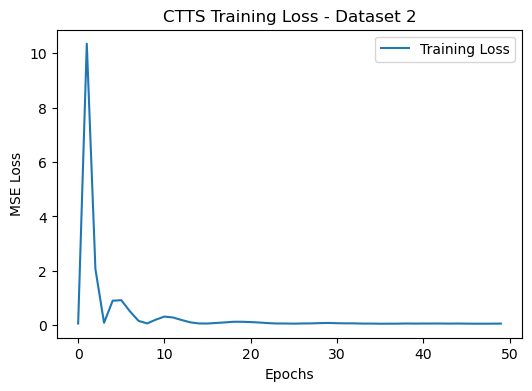

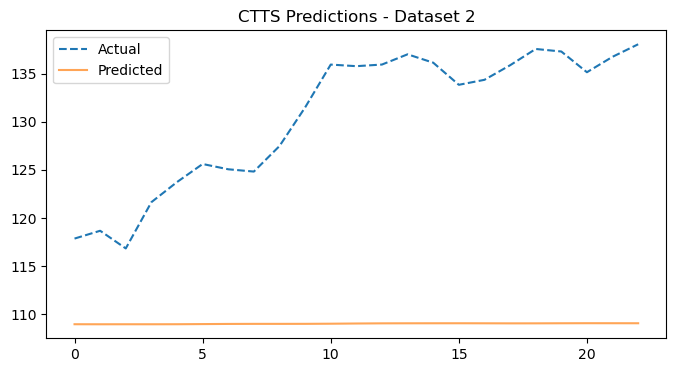


🔹 Training on data/synthetic_series_3.csv 🔹


/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0: Loss 0.0811
Epoch 10: Loss 0.3069
Epoch 20: Loss 0.1039
Epoch 30: Loss 0.0646
Epoch 40: Loss 0.0542


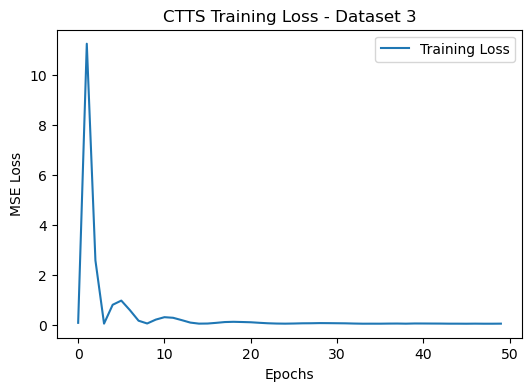

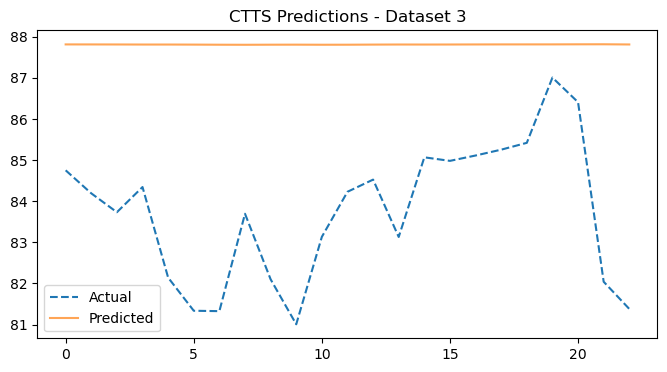

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.ctts import CTTS

# Load synthetic data
def load_synthetic_data(file_path, input_size=30):
    df = pd.read_csv(file_path)
    prices = df["Price"].values
    
    # Normalize data
    min_price, max_price = np.min(prices), np.max(prices)
    prices = (prices - min_price) / (max_price - min_price)

    # Prepare sequences
    X, Y = [], []
    for i in range(len(prices) - input_size):
        X.append(prices[i:i+input_size])
        Y.append(prices[i+input_size])
    
    X, Y = np.array(X), np.array(Y)
    return torch.tensor(X, dtype=torch.float32).unsqueeze(1), torch.tensor(Y, dtype=torch.float32), min_price, max_price

# Training function
def train_ctts(model, X_train, Y_train, epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []
    X_train, Y_train = X_train.to(device), Y_train.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X_train).squeeze()
        loss = criterion(preds, Y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.4f}")

    return losses

# Prediction function
def evaluate_ctts(model, X_test, min_price, max_price):
    model.eval()
    with torch.no_grad():
        preds = model(X_test.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))).cpu().numpy()
    
    # Rescale predictions back to original price scale
    return preds * (max_price - min_price) + min_price

# Load and train on 3 datasets
file_paths = ["data/synthetic_series_1.csv", "data/synthetic_series_2.csv", "data/synthetic_series_3.csv"]
input_size = 30
epochs = 50

for idx, file_path in enumerate(file_paths):
    print(f"\n🔹 Training on {file_path} 🔹")

    # Load data
    X, Y, min_price, max_price = load_synthetic_data(file_path, input_size)

    # Split into train & test (90% train, 10% test)
    split_idx = int(len(X) * 0.9)
    X_train, Y_train = X[:split_idx], Y[:split_idx]
    X_test, Y_test = X[split_idx:], Y[split_idx:]

    # Initialize & train model
    model = CTTS(input_channels=1, hidden_units=64, output_size=1)
    losses = train_ctts(model, X_train, Y_train, epochs=epochs)

    # Plot training loss
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title(f"CTTS Training Loss - Dataset {idx+1}")
    plt.legend()
    plt.show()

    # Evaluate model
    predictions = evaluate_ctts(model, X_test, min_price, max_price)

    # Plot actual vs predicted
    plt.figure(figsize=(8, 4))
    plt.plot(Y_test.numpy() * (max_price - min_price) + min_price, label="Actual", linestyle="dashed")
    plt.plot(predictions, label="Predicted", alpha=0.7)
    plt.title(f"CTTS Predictions - Dataset {idx+1}")
    plt.legend()
    plt.show()


2️⃣ Temporal Fusion Transformer (TFT)

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([14, 1])) that is different to the input size (torch.Size([14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduc

Epoch 0, Loss: 11600.3812
Epoch 10, Loss: 6527.6227
Epoch 20, Loss: 1958.4176
Epoch 30, Loss: 334.7426
Epoch 40, Loss: 149.7119


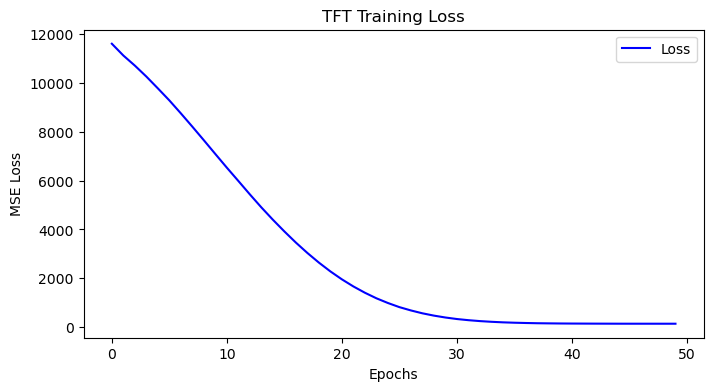

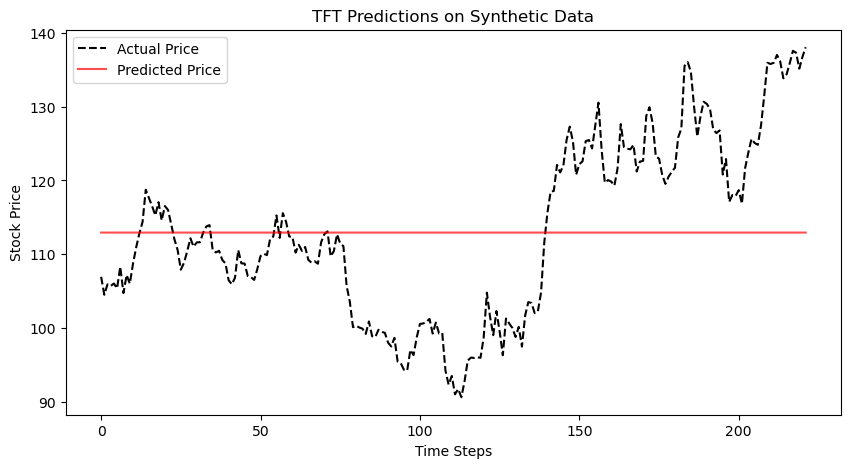

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from models.tft import TemporalFusionTransformer  # Ensure your model is correctly implemented

# Load synthetic data
df = pd.read_csv("data/synthetic_series_2.csv", parse_dates=["Date"])
prices = df["Price"].values

# Hyperparameters
input_size = 30  # Sequence length
batch_size = 16
epochs = 50
lr = 0.001

# Prepare dataset
X_train = [prices[i:i+input_size] for i in range(len(prices) - input_size)]
Y_train = [prices[i+input_size] for i in range(len(prices) - input_size)]

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add feature dim (batch, seq_len, input_dim)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)   # Make target shape (batch, 1)

# DataLoader for batching
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalFusionTransformer(input_size=1, hidden_units=64, num_heads=4, num_layers=2, output_size=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch).squeeze()
        loss = criterion(preds, Y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train_loader))
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("TFT Training Loss")
plt.legend()
plt.show()

# Generate test predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_train.to(device)).cpu().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(Y_train.numpy(), label="Actual Price", linestyle="dashed", color="black")
plt.plot(test_preds, label="Predicted Price", color="red", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("TFT Predictions on Synthetic Data")
plt.legend()
plt.show()


3️⃣ DeepAR Model (Autoregressive RNN)

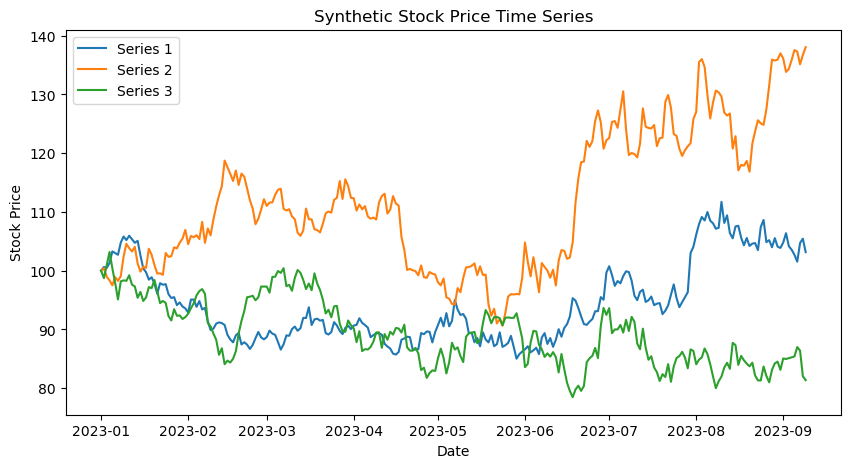

/opt/anaconda3/envs/finance/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([222, 1])) that is different to the input size (torch.Size([222, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/50 - Loss: 8794.1455
Epoch 10/50 - Loss: 8584.7500
Epoch 20/50 - Loss: 8299.2549
Epoch 30/50 - Loss: 8031.9600
Epoch 40/50 - Loss: 7792.1348


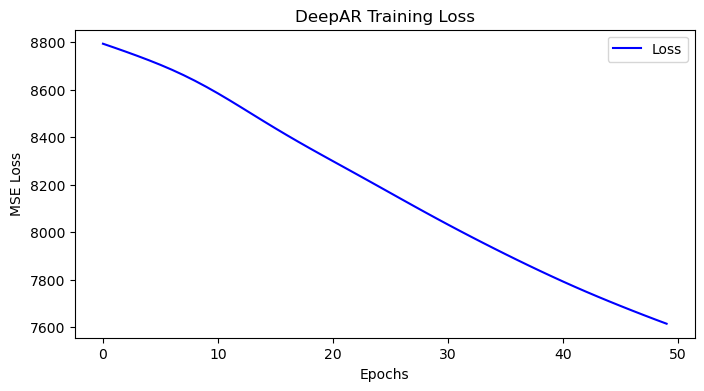

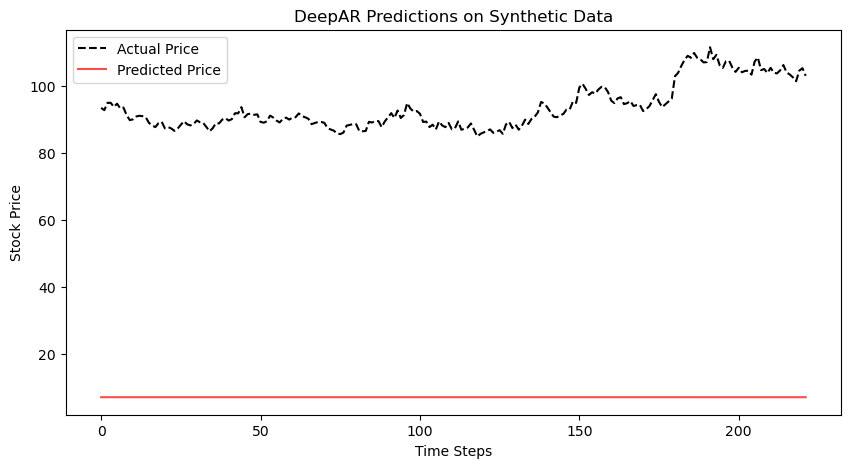

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.deepar import DeepAR  # Import your DeepAR model

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Load Synthetic Data (3 CSVs)
data_paths = ["data/synthetic_series_1.csv", "data/synthetic_series_2.csv", "data/synthetic_series_3.csv"]
datasets = [pd.read_csv(file, parse_dates=["Date"]) for file in data_paths]

# 📌 Visualize the loaded data
plt.figure(figsize=(10, 5))
for i, df in enumerate(datasets):
    plt.plot(df["Date"], df["Price"], label=f"Series {i+1}")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Synthetic Stock Price Time Series")
plt.legend()
plt.show()

# 📌 Data Preparation (Convert to Sequences)
def create_sequences(prices, seq_length=30):
    X, Y = [], []
    for i in range(len(prices) - seq_length):
        X.append(prices[i : i + seq_length])
        Y.append(prices[i + seq_length])
    return np.array(X), np.array(Y)

# Select **1st synthetic series** for training
selected_series = datasets[0]["Price"].values

# Generate sequences
seq_length = 30
X_train, Y_train = create_sequences(selected_series, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, input_size)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(-1)  # (batch, 1)

# 📌 Initialize DeepAR Model
input_size = 1  # Single feature (price)
hidden_units = 64
model = DeepAR(input_size=input_size, hidden_units=hidden_units).to(DEVICE)

# 📌 Loss Function & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 📌 Training Loop
epochs = 50
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train.to(DEVICE))
    loss = criterion(preds.squeeze(), Y_train.to(DEVICE))
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.4f}")

# 📌 Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("DeepAR Training Loss")
plt.legend()
plt.show()

# 📌 Test Predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_train.to(DEVICE)).cpu().numpy()

# 📌 Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(Y_train.numpy(), label="Actual Price", linestyle="dashed", color="black")
plt.plot(test_preds[:, -1, 0], label="Predicted Price", color="red", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("DeepAR Predictions on Synthetic Data")
plt.legend()
plt.show()
